In [1]:
from transformers import (
    AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoModel,
    BartForConditionalGeneration, BartTokenizer, pipeline
)

from transformers import GPT2LMHeadModel as GPT2
from transformers import GPT2TokenizerFast as GPT2T
import pandas as pd


In [ ]:
pipe = pipeline('text')

In [11]:
# show available models like "kogpt
# "t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"

model_name= 'skt/kogpt2-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
from torch.utils.data import Dataset

class TextStyleTransferDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.df = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index, :]

        # 구어체
        text1 = row['gloss']
        text2 = row['spoken']
        encoder_text = f"반말로 변환: {text1}"

        # 글로스
        # text1 = row['spoken']
        # text2 = row['gloss']
        # encoder_text = f"글로스 말투로 변환: {text1}"

        decoder_text = f"{text2}{self.tokenizer.eos_token}"
        model_inputs = self.tokenizer(encoder_text, max_length=64, truncation=True)
        with self.tokenizer.as_target_tokenizer():
            labels = tokenizer(decoder_text, max_length=64, truncation=True)
        model_inputs['labels'] = labels['input_ids']
        # del model_inputs['token_type_ids']

        return model_inputs

In [17]:
def generate_text(pipe, text, direction, num_return_sequences=5, max_length=100):
    if direction == 'g2t': text = f"구어체로 변환: {text}"
    else: text = f"글로스 말투로 변환: {text}"
    out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
    return [x['generated_text'] for x in out]

In [18]:
train_dataset = 'MY_DATA/shots/gloss2text/0-shot.csv'
model_pth = 'model/gpttest'

In [19]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(train_dataset)
dataset = TextStyleTransferDataset(df, tokenizer)
df_train, df_test = train_test_split(dataset, test_size=0.001, random_state=42)
data_collator = DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)

training_args = Seq2SeqTrainingArguments(
    output_dir=model_pth,  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=30,  # number of training epochs
    per_device_train_batch_size=256,  # batch size for training
    per_device_eval_batch_size=256,  # batch size for evaluation
    eval_steps=500,  # Number of update steps between two evaluations.
    save_steps=1000,  # after # steps model is saved
    warmup_steps=300,  # number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=df_train,
    eval_dataset=df_test,
    # compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(model_pth)

***** Running training *****
  Num examples = 2761
  Num Epochs = 30
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 330
Using pad_token, but it is not set yet.


ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [9]:
from transformers import pipeline

model_name= 'skt/ko-gpt-trinity-1.2B-v0.5'
pipe = pipeline('text-generation', model=model_name, max_length=100)
pipe('당신 이름 무엇 ? > 당신의 이름은 무엇입니까?\n'
     '아니오 나 청인 . > 아니오. 나는 청인입니다.\n'
     '가족 소개 주세요 ?')

[{'generated_text': '당신 이름 무엇 ? > 당신의 이름은 무엇입니까?\n아니오 나 청인 . > 아니오. 나는 청인입니다.\n가족 소개 주세요 ? > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다. > 가족은 없습니다.'}]

In [12]:
from transformers import T5ForConditionalGeneration,AutoTokenizer
path = "kimdwan/t5-base-korean-summarize-LOGAN"
model = T5ForConditionalGeneration.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)

#여기에 원하는 문장을 입력하시길 바랍니다. 
text= """ (서울=뉴스1) 이비슬 기자 = 윤상현 국민의힘 의원은 18일 이철규 사무총장의 '승선불가' 발언과 관련해 "무엇이 위기인지 본질을 잘 모르고 있다는 게 진짜 위기"라고 말했다.

윤 의원은 이날 SBS 라디오 '김태현의 정치쇼' 인터뷰에서 "국민의힘이 더불어민주당을 빼놓고 제3정당이 나오면 지지율이 비슷하다. 이것이 위기 아니냐. 그런데 이런 것에 관해서 (이야기)하면 이것을 이상하게 받아들이는데, 그래서 위기가 위기라는 것"이라고 말했다.

윤 의원은 "수도권 싸움은 영남권 싸움과 다르다. 수도권 거의 모든 지역이 1000표, 1500표 싸움 아니냐"며 "제3정당이 나왔을 때 국민의힘 표를 뺏어간다. 승부를 가르는 결정적인 요인이 될 수 있기 때문에 3지대에 있는 사람들도 포용하고 전략을 갖추는 것에 대해 말씀드린 것"이라고 말했다.

앞서 이 사무총장은 지난 16일 비공개 의원총회에서 "배를 침몰시키려는 승객은 함께하지 못한다"고 발언했다. 이를 두고 내년 총선 수도권 위기론과 당 지도부 책임을 언급하며 공개적으로 비판 입장을 밝혀온 윤 의원이 발언의 표적이었다는 관측이 나왔다.

윤 의원은 이 사무총장의 발언이 자신을 겨냥했다는 관측과 관련해 "당에 대한 충정으로 말씀드린 것"이라며 "당이라는 배를 좌초시키려는 의도는 없었다"고 말했다.

윤 의원은 "당이라는 배가 좌초되거나 어려워지면 당 지도부 의원이 아니라 수도권에 있는 의원이 가장 먼저 죽는다"며 "누구를 기분 나쁘게 할 마음으로 (이야기)한 것이 아니라 당에 대한 진정성으로 이야기한 것"이라고 했다."""
prefix = "summarize : " + text

token = tokenizer(prefix ,return_tensors="pt")
output = model.generate(input_ids=token["input_ids"],attention_mask = token["attention_mask"])
text = tokenizer.decode(output[0])[5:-4]
text

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 128). Running this sequence through the model will result in indexing errors


"윤 의원은 이 사무총장의 '승선불가' 발언과 관련해 무엇이 위기인지 본질을 잘 모르는 것이 위기라고 말하며 수도권 배를 침몰시키려는 승객은 함께하지 못한다는 말을 공개적으로 비판했다."

In [13]:
!pip install Rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: pytorch-lightning 1.5.6 has a non-standard dependency specifier torch>=1.7.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [23]:
from rouge import Rouge
import mecab_ko as Mecab

text = '우리 둘 친하제 지내다 괜찮다'
prefix = '우리 둘 친하게 지내다 괜찮다'

rouge = Rouge()
scores = rouge.get_scores(text, prefix)

In [24]:
scores[0]['rouge-1']['f']

0.7999999950000002

In [42]:
4^20

16

In [ ]:
T = int(input())

for test_case in range(1, T + 1):
    ls = list(map(int, input().split()))
    print(f'#{test_case} {sum([i for i in ls if i % 2 == 1])}')

In [43]:
!pip install bertviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 27.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 15.9 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.5.6 has a non-standard dependency specifier torch>=1.7.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they re

In [3]:
from transformers import (
    AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoModel,
    BartForConditionalGeneration, BartTokenizer, pipeline
)
from bertviz import head_view, model_view
from transformers import GPT2LMHeadModel as GPT2
from transformers import GPT2TokenizerFast as GPT2T
import pandas as pd
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version)

model_name = "gogamza/kobart-base-v2"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)



Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:
# model_name = "gogamza/kobart-base-v2"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

sentence_a = "가족 많다 부럽다"
sentence_b = "가족이 많아 부럽군요."
encoder_input_ids = tokenizer(sentence_a)
decoder_input_ids = tokenizer(sentence_b)
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']

attention = model(input_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

# head_view(attention, tokens, sentence_b_start)
outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)
encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens=decoder_text
)

AttributeError: 

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = "Noto Sans CJK JP" 

# Load the model and tokenizer
model_name = "gogamza/kobart-base-v2"
model_name = "./model/my"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v2")

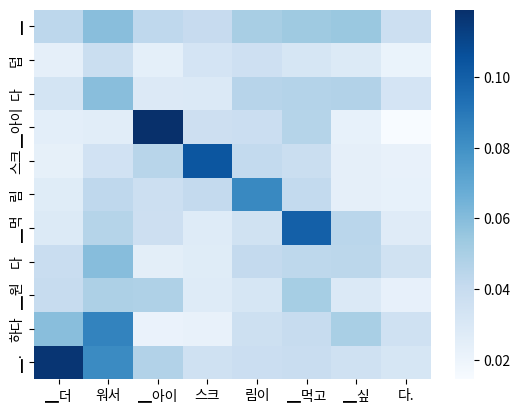

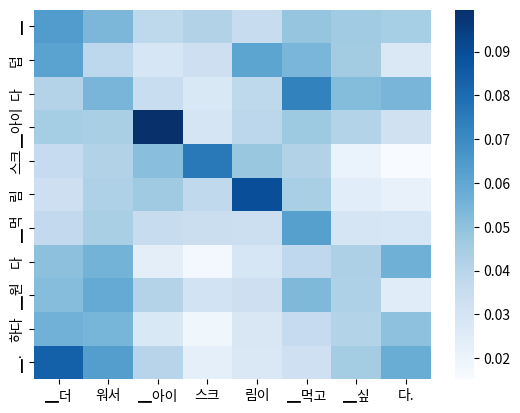

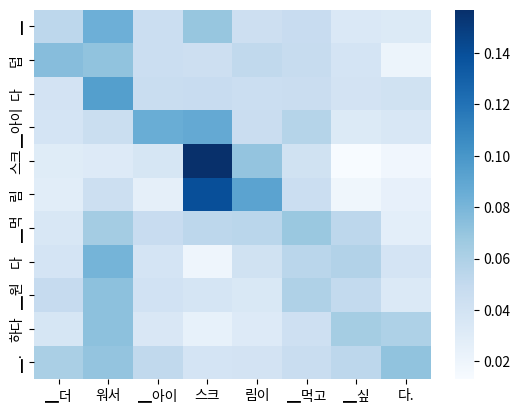

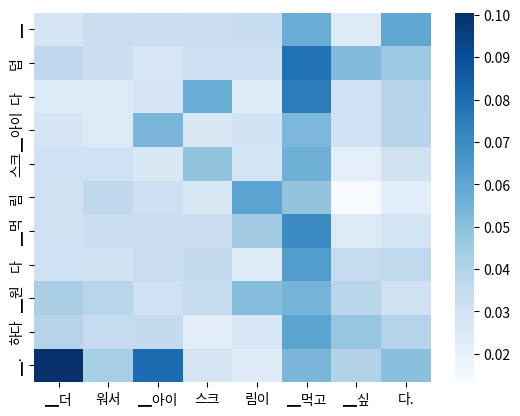

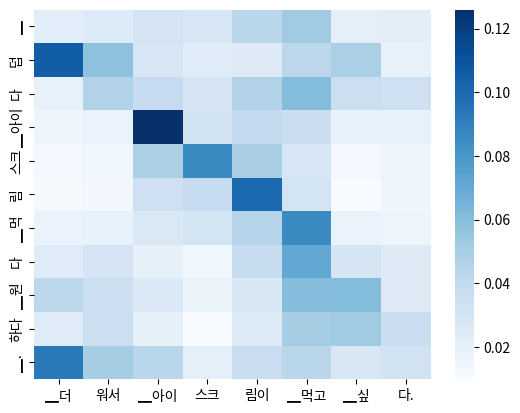

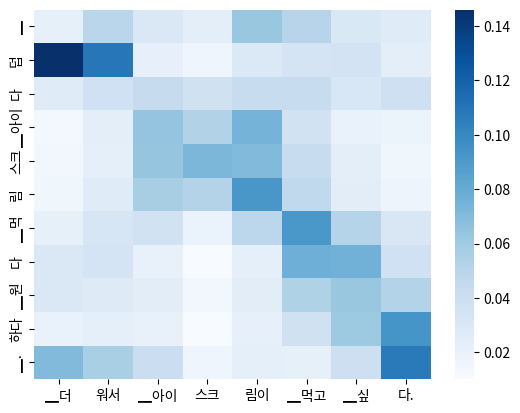

TypeError: plot_attention() missing 1 required positional argument: 'n'

In [9]:
# Prepare the input sentences
# sentence_a = "구어체로 변환: 식사 시간 언제 ?"
# sentence_b = "식사 시간이 언제인가요?"

# sentence_a = "구어체로 변환: 수업 자료 어디 받다 ?"
# sentence_b = "수업 자료 어디서 받아요?"

# sentence_a = "구어체로 변환: 어제 편지 받다 너무 행복 ."
# sentence_b = "어제 편지를 받았는데 너무 행복했다."

sentence_a = "덥다 아이스크림 먹다 원하다 ."
sentence_b = "더워서 아이스크림이 먹고 싶다."

# Tokenize and encode sentences
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', padding=True, max_length=512, truncation=True)
input_ids = inputs['input_ids']

# Generate outputs
outputs = model(input_ids, decoder_input_ids=input_ids, output_attentions=True)

# Extract encoder and decoder attentions
encoder_attentions = outputs.encoder_attentions
decoder_attentions = outputs.decoder_attentions

# Function to visualize attention
def plot_attention(attention, tokens, n):
    # Calculate the average attention weights across all heads and detach from the graph
    avg_attention = torch.mean(attention, dim=1)[0].detach()
    avg_attention_np = avg_attention.numpy()
    # print(avg_attention_np[:10, 10:].shape)
    sns.heatmap(avg_attention_np[:n, n:], xticklabels=tokens[n:], yticklabels=tokens[:n], cmap='Blues')
    plt.show()

# Extract tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
# print(encoder_attentions)
n = len(tokenizer(sentence_b)['input_ids'])
# Visualize attention for the first head of the encoder
# Optionally, visualize attention for the first head of the decoder

plot_attention(encoder_attentions[0], tokens, len(tokens)-n)
plot_attention(encoder_attentions[1], tokens, len(tokens)-n)
plot_attention(encoder_attentions[2], tokens, len(tokens)-n)
plot_attention(encoder_attentions[3], tokens, len(tokens)-n)
plot_attention(encoder_attentions[4], tokens, len(tokens)-n)
plot_attention(encoder_attentions[5], tokens, len(tokens)-n)

plot_attention(decoder_attentions[0], tokens)
plot_attention(decoder_attentions[1], tokens)
plot_attention(decoder_attentions[2], tokens)
plot_attention(decoder_attentions[3], tokens)
plot_attention(decoder_attentions[4], tokens)
plot_attention(decoder_attentions[5], tokens)